# Для подбора моделей

In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDClassifier

In [5]:
train = pd.read_excel('train.xlsx')
test = pd.read_csv('test (2).csv')

In [6]:
train

,Unnamed: 0,Age,FamilySize,PastDueLess_60,PastDue60_90,PastDue90_More,DebtRatio,MonthlyIncome,TotalBalanceDivideCreditLimits,OpenLoans,RealEstateLoans,Target
0,0,56,1.0,1,0,0,0.060571859,5315.0,0.498037,9,0,0
1,1,38,1.0,0,0,0,0.176964607,3333.0,0.060600,5,0,0
2,2,42,2.0,1,0,0,0.412141333,8433.0,0.675398,8,1,0
3,3,34,1.0,2,0,0,0.341436766,3660.0,0.630550,10,0,0
4,4,102,1.0,0,0,0,0.273844353,3417.0,0.109642,7,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
99996,99996,83,0.0,1,0,0,0.0,NaN,1.000000,4,0,0
99997,99997,65,0.0,0,0,0,1373.0,NaN,0.084077,4,1,0
99998,99998,39,4.0,0,0,0,3200.0,NaN,0.509142,20,2,0
99999,99999,58,2.0,0,0,0,0.277908721,14000.0,0.120541,13,2,1


In [7]:
# Заполнение пропусков
train['MonthlyIncome'].fillna(train['MonthlyIncome'].median(), inplace=True)
train['FamilySize'].fillna(train['FamilySize'].median(), inplace=True)
test['MonthlyIncome'].fillna(train['MonthlyIncome'].median(), inplace=True)
test['FamilySize'].fillna(train['FamilySize'].median(), inplace=True)
train['DebtRatio'] = pd.to_numeric(train['DebtRatio'], errors='coerce').fillna(0).astype(float)
test['DebtRatio'] = pd.to_numeric(test['DebtRatio'], errors='coerce').fillna(0).astype(float)
train.drop(columns=['Unnamed: 0'], inplace=True)

<ipython-input-7-6fa6829f2c60>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['MonthlyIncome'].fillna(train['MonthlyIncome'].median(), inplace=True)
<ipython-input-7-6fa6829f2c60>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value

In [8]:
print(f'Размер до удаления выбросов: {train.shape}')

Размер до удаления выбросов: (100001, 11)


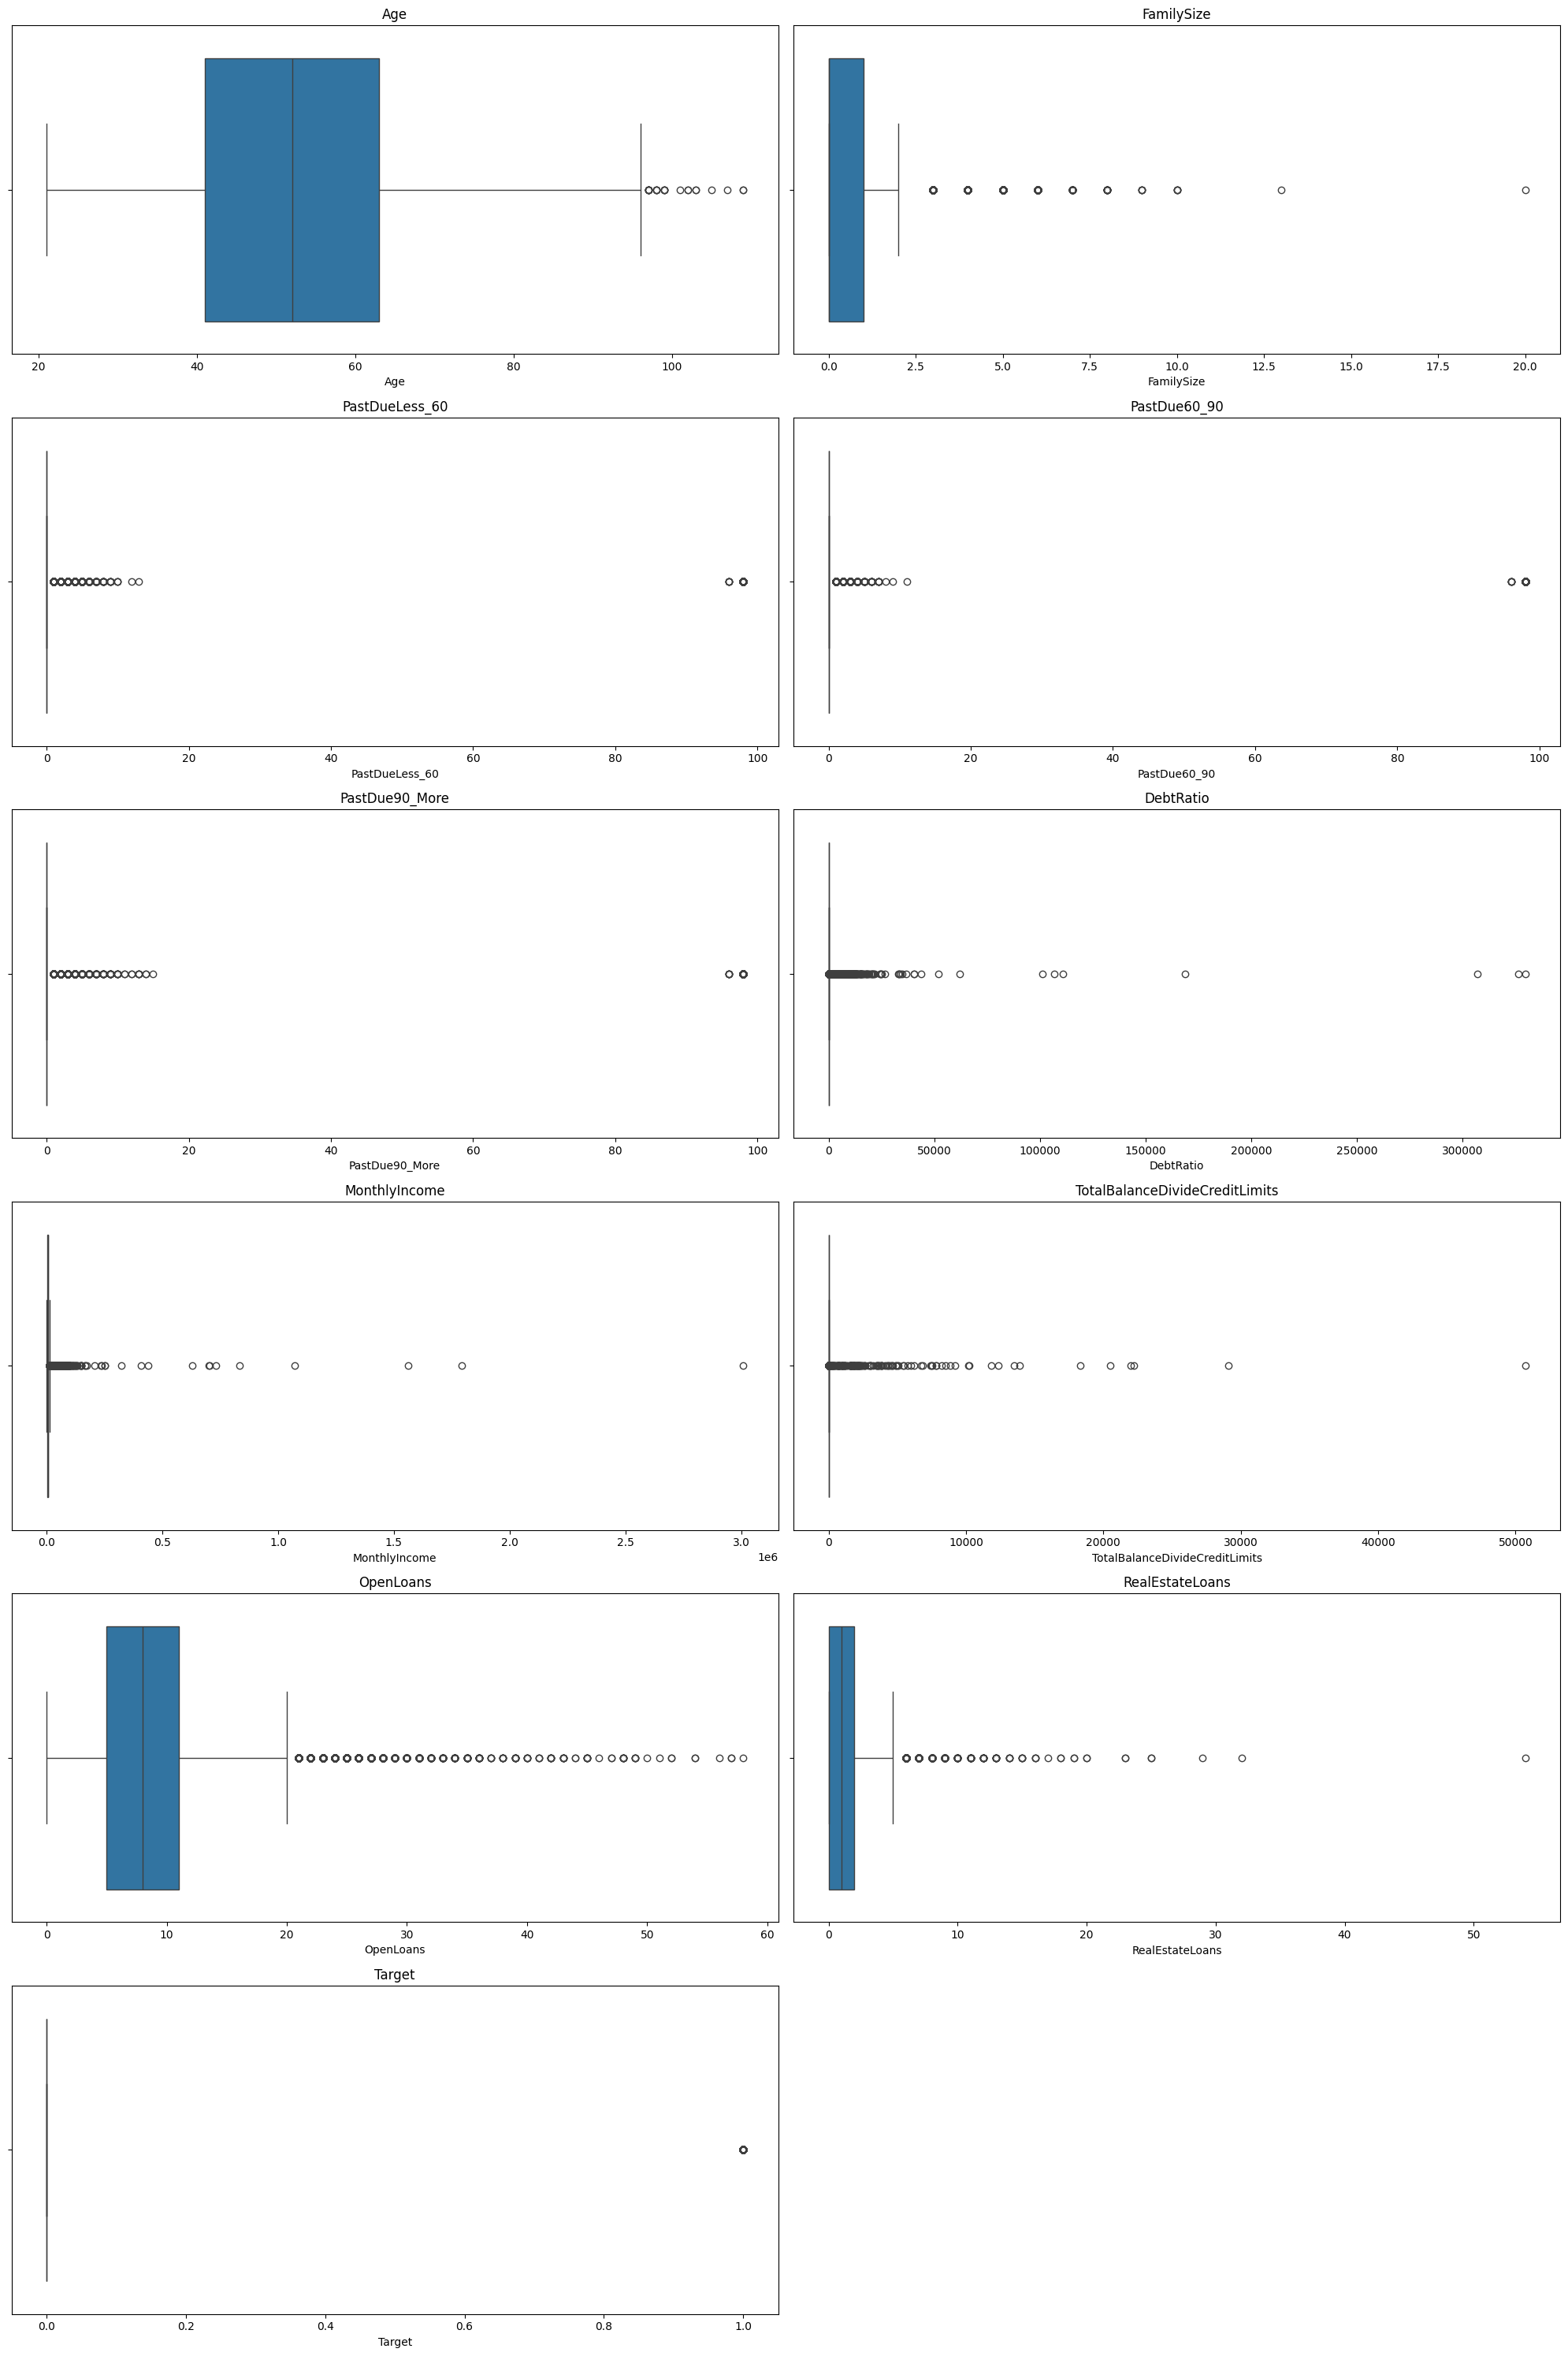

In [9]:
# Выбираем числовые признаки
numeric_cols = train.select_dtypes(include=['number']).columns

# Строим боксплоты
plt.figure(figsize=(20, 30))  # увеличиваем размер фигуры для всех графиков

for idx, col in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols) // 2 + 1, 2, idx)
    sns.boxplot(x=train[col])
    plt.title(col)

plt.tight_layout()
plt.show()


In [10]:
# Определяем интересующие признаки
selected_cols = ['Age', 'FamilySize', 'RealEstateLoans']

# Считаем Z-оценку только для выбранных признаков
z_scores = np.abs(zscore(train[selected_cols]))

# Выбираем только строки без выбросов
train = train[(z_scores < 3).all(axis=1)]
print(f'Размер после удаления выбросов: {train.shape}')

Размер после удаления выбросов: (98383, 11)


In [11]:
# Отделяем признаки и целевую переменную
X = train.drop('Target', axis=1)
y = train['Target']

In [12]:
# Масштабирование признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
test_scaled = scaler.transform(test.drop('ID', axis=1))

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [38]:
xgb2 = XGBClassifier(random_state=42, learning_rate=0.1, max_depth=3, n_estimators=200)

In [39]:
xgb2.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [40]:
preds_xgb = xgb2.predict_proba(X_val)[:,1]
print('AUC XGB:', roc_auc_score(y_val, preds_xgb))

AUC XGB: 0.8640056093389779


In [87]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

params_xgb = {
    'n_estimators': [180, 200, 240],
    'max_depth': [2, 3, 5],
    'learning_rate': [0.15, 0.1, 0.88]
}

grid_xgb = GridSearchCV(xgb, params_xgb, cv=3, scoring='roc_auc', verbose=2)
grid_xgb.fit(X_train, y_train)

best_xgb = grid_xgb.best_estimator_

preds_xgb = best_xgb.predict_proba(X_val)[:,1]
print('AUC XGB:', roc_auc_score(y_val, preds_xgb))


Fitting 3 folds for each of 27 candidates, totalling 81 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:36:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.15, max_depth=2, n_estimators=180; total time=   0.5s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:36:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.15, max_depth=2, n_estimators=180; total time=   0.4s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:36:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.15, max_depth=2, n_estimators=180; total time=   0.4s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:36:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.15, max_depth=2, n_estimators=200; total time=   0.5s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:36:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.15, max_depth=2, n_estimators=200; total time=   0.5s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:36:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.15, max_depth=2, n_estimators=200; total time=   0.5s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:36:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.15, max_depth=2, n_estimators=240; total time=   0.5s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:36:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.15, max_depth=2, n_estimators=240; total time=   0.6s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:36:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.15, max_depth=2, n_estimators=240; total time=   0.9s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:36:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.15, max_depth=3, n_estimators=180; total time=   0.5s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:36:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.15, max_depth=3, n_estimators=180; total time=   0.5s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:36:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.15, max_depth=3, n_estimators=180; total time=   0.6s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:36:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.15, max_depth=3, n_estimators=200; total time=   3.9s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:36:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.15, max_depth=3, n_estimators=200; total time=   4.5s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:36:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.15, max_depth=3, n_estimators=200; total time=   2.5s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:36:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.15, max_depth=3, n_estimators=240; total time=   3.0s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:36:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.15, max_depth=3, n_estimators=240; total time=   3.6s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.15, max_depth=3, n_estimators=240; total time=   3.0s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.15, max_depth=5, n_estimators=180; total time=   1.8s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.15, max_depth=5, n_estimators=180; total time=   2.0s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.15, max_depth=5, n_estimators=180; total time=   0.7s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.15, max_depth=5, n_estimators=200; total time=   0.8s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.15, max_depth=5, n_estimators=200; total time=   2.4s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.15, max_depth=5, n_estimators=200; total time=   1.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.15, max_depth=5, n_estimators=240; total time=   0.9s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.15, max_depth=5, n_estimators=240; total time=   0.9s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.15, max_depth=5, n_estimators=240; total time=   0.9s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=2, n_estimators=180; total time=   0.4s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=2, n_estimators=180; total time=   0.5s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=2, n_estimators=180; total time=   0.5s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=2, n_estimators=200; total time=   0.5s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=2, n_estimators=200; total time=   0.5s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=2, n_estimators=200; total time=   0.5s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=2, n_estimators=240; total time=   0.6s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=2, n_estimators=240; total time=   0.6s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=2, n_estimators=240; total time=   0.6s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=180; total time=   0.5s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=180; total time=   0.5s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=180; total time=   0.5s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=   0.6s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=   1.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=240; total time=   0.7s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=240; total time=   0.6s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=240; total time=   0.7s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=180; total time=   0.7s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=180; total time=   0.7s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=180; total time=   0.7s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time=   0.8s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time=   0.8s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time=   0.8s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=240; total time=   0.9s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=240; total time=   0.9s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=240; total time=   0.9s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.88, max_depth=2, n_estimators=180; total time=   0.4s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.88, max_depth=2, n_estimators=180; total time=   1.5s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.88, max_depth=2, n_estimators=180; total time=   1.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.88, max_depth=2, n_estimators=200; total time=   0.6s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.88, max_depth=2, n_estimators=200; total time=   0.5s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.88, max_depth=2, n_estimators=200; total time=   0.5s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.88, max_depth=2, n_estimators=240; total time=   0.6s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.88, max_depth=2, n_estimators=240; total time=   0.5s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.88, max_depth=2, n_estimators=240; total time=   0.6s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.88, max_depth=3, n_estimators=180; total time=   0.5s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.88, max_depth=3, n_estimators=180; total time=   0.5s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.88, max_depth=3, n_estimators=180; total time=   0.5s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.88, max_depth=3, n_estimators=200; total time=   0.6s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.88, max_depth=3, n_estimators=200; total time=   0.6s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.88, max_depth=3, n_estimators=200; total time=   0.6s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.88, max_depth=3, n_estimators=240; total time=   0.7s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.88, max_depth=3, n_estimators=240; total time=   0.6s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.88, max_depth=3, n_estimators=240; total time=   0.7s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.88, max_depth=5, n_estimators=180; total time=   0.7s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.88, max_depth=5, n_estimators=180; total time=   0.8s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.88, max_depth=5, n_estimators=180; total time=   2.4s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.88, max_depth=5, n_estimators=200; total time=   1.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.88, max_depth=5, n_estimators=200; total time=   0.8s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.88, max_depth=5, n_estimators=200; total time=   0.8s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.88, max_depth=5, n_estimators=240; total time=   1.0s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.88, max_depth=5, n_estimators=240; total time=   1.0s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.88, max_depth=5, n_estimators=240; total time=   1.0s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


AUC XGB: 0.8635670920107107


In [76]:
best_params = grid_xgb.best_params_
print("Лучшие параметры XGBoost:", best_params)

Лучшие параметры XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}


In [26]:
rf2 = RandomForestClassifier(random_state=42,max_depth=10, min_samples_split=3, n_estimators=230, max_features='sqrt', class_weight='balanced', oob_score=True)

In [27]:
rf2.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=3, n_estimators=230, oob_score=True,
                       random_state=42)

In [28]:
preds_rf = rf2.predict_proba(X_val)[:,1]
print('AUC RF:', roc_auc_score(y_val, preds_rf))

AUC RF: 0.8598095540415426


In [89]:
rf = RandomForestClassifier(random_state=42)

params_rf = {
    'n_estimators': [180, 200, 240],
    'max_depth': [8, 10, 12],
    'min_samples_split': [1, 2, 3]
}

grid_rf = GridSearchCV(rf, params_rf, cv=3, scoring='roc_auc', verbose=2)
grid_rf.fit(X_train, y_train)

best_rf = grid_rf.best_estimator_

preds_rf = best_rf.predict_proba(X_val)[:,1]
print('AUC RF:', roc_auc_score(y_val, preds_rf))


Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END .max_depth=8, min_samples_split=1, n_estimators=180; total time=   0.0s
[CV] END .max_depth=8, min_samples_split=1, n_estimators=180; total time=   0.0s
[CV] END .max_depth=8, min_samples_split=1, n_estimators=180; total time=   0.0s
[CV] END .max_depth=8, min_samples_split=1, n_estimators=200; total time=   0.0s
[CV] END .max_depth=8, min_samples_split=1, n_estimators=200; total time=   0.0s
[CV] END .max_depth=8, min_samples_split=1, n_estimators=200; total time=   0.0s
[CV] END .max_depth=8, min_samples_split=1, n_estimators=240; total time=   0.0s
[CV] END .max_depth=8, min_samples_split=1, n_estimators=240; total time=   0.0s
[CV] END .max_depth=8, min_samples_split=1, n_estimators=240; total time=   0.0s
[CV] END .max_depth=8, min_samples_split=2, n_estimators=180; total time=  11.5s
[CV] END .max_depth=8, min_samples_split=2, n_estimators=180; total time=  11.5s
[CV] END .max_depth=8, min_samples_split=2, n_es

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
27 fits failed out of a total of 81.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
27 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_

AUC RF: 0.8657200924421983


In [90]:
best_paramsrf = grid_rf.best_params_
print("Лучшие параметры XGBoost:", best_paramsrf)

Лучшие параметры XGBoost: {'max_depth': 10, 'min_samples_split': 3, 'n_estimators': 240}


In [41]:
# Создаем ансамбль (усреднение вероятностей через soft voting)
ensemble = VotingClassifier(
    estimators=[
        ('xgb', xgb2),
        ('rf', rf2)
    ],
    voting='soft',  # 'soft' = усреднение вероятностей
    n_jobs=-1
)

# Обучаем ансамбль
ensemble.fit(X_train, y_train)

# Предсказания ансамбля
ensemble_preds = ensemble.predict_proba(X_val)[:, 1]

# Оцениваем качество
print('AUC Ensemble:', roc_auc_score(y_val, ensemble_preds))

AUC Ensemble: 0.8639465514418339


In [42]:
test_preds_xgb = xgb2.predict_proba(test_scaled)[:,1]
test_preds_rf = rf2.predict_proba(test_scaled)[:,1]
test_preds_ensemble = ensemble.predict_proba(test_scaled)[:, 1]

In [43]:
submission_xgb = pd.DataFrame({
    'ID': test['ID'],
    'Target': test_preds_xgb
})

submission_rf = pd.DataFrame({
    'ID': test['ID'],
    'Target': test_preds_rf
})

submission_ensemble = pd.DataFrame({
    'ID': test['ID'],
    'Target': test_preds_ensemble
})

# Сохранение
submission_xgb.to_csv('/content/submission_xgb.csv', index=False)
submission_rf.to_csv('/content/submission_rf.csv', index=False)
submission_ensemble.to_csv('/content/submission_ensemble.csv', index=False)
